# Latency and capacity estimation for a network connection from asymmetric measurements

In [161]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import urllib
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

## First data set

In [162]:
url = 'http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz'
urllib.request.urlretrieve(url, '/tmp/liglab2.log.gz')
os.system('gunzip /tmp/liglab2.log.gz')
os.system('sed -e "s/\[/ /"  -e "s/]/,/" -e "s/bytes.*time=/,/" -e "s/ms/ /" /tmp/liglab2.log > /tmp/ping_campus.log')
raw_data = pd.read_table("/tmp/ping_campus.log", header=None, sep=',', engine='python')

In [163]:
raw_data.columns = ['time', 'bytes','transmission_time']
raw_data

,time,bytes,transmission_time
0,1.421762e+09,665,22.50
1,1.421762e+09,1373,21.20
2,1.421762e+09,262,21.20
3,1.421762e+09,1107,23.30
4,1.421762e+09,1128,1.41
...,...,...,...
44408,1.421771e+09,1338,1.47
44409,1.421771e+09,1515,7.02
44410,1.421771e+09,1875,2.33
44411,1.421771e+09,1006,1.61


We will now look if we have missing data

In [164]:
raw_data[raw_data.isnull().any(axis=1)]

,time,bytes,transmission_time
12,1.421762e+09,21 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
116,1.421762e+09,9 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
314,1.421762e+09,9 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
508,1.421762e+09,9 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
590,1.421762e+09,18 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
...,...,...,...
43730,1.421771e+09,14 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
43985,1.421771e+09,12 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
44024,1.421771e+09,8 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
44170,1.421771e+09,8 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN


We can see that we have 337 lines where the transmission time is missing. We will then delete them.

In [165]:
data = raw_data.dropna().copy()
data = data.reset_index(drop = True)
data

,time,bytes,transmission_time
0,1.421762e+09,665,22.50
1,1.421762e+09,1373,21.20
2,1.421762e+09,262,21.20
3,1.421762e+09,1107,23.30
4,1.421762e+09,1128,1.41
...,...,...,...
44031,1.421771e+09,1338,1.47
44032,1.421771e+09,1515,7.02
44033,1.421771e+09,1875,2.33
44034,1.421771e+09,1006,1.61


We need convert the date and time in float to use them.

In [166]:
data['time'] = data['time'].astype(float)
data['transmission_time'] = data['transmission_time'].astype(float)
data['bytes'] = data['bytes'].astype(int)

### Question 1/

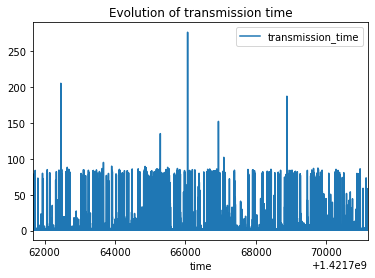

In [167]:
data.plot(x='time', y='transmission_time', title="Evolution of transmission time")

This is not really readable. We will take a different time scale to have a better view of the data.

In [168]:
(data['time'][44035] - data['time'][0]) / 3600

2.6402189027600818

The difference time between the first byte sent and the last one is about 2,6 hours. We will plot only the first quarter of the data to see what it looks like.

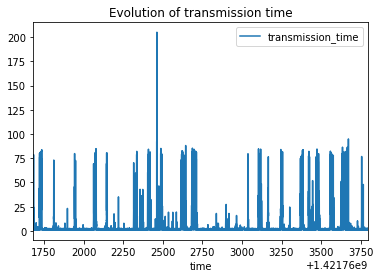

In [169]:
data[0:10000].plot(x='time', y='transmission_time', title="Evolution of transmission time")

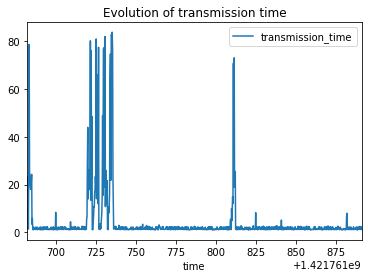

In [170]:
data[0:1000].plot(x='time', y='transmission_time', title="Evolution of transmission time")

We can not say yet why we have this kind of graphic. Is the variations of time only depend on the size of the packet? To answer, we need to continue our analysis.

### Question 2/

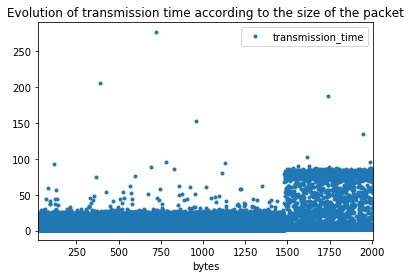

In [171]:
data.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of the packet", style='.')

We observe a "disruption" when the packet size is more than 1500 bytes. For packets whose size is between 0 and 1500 bytes, the transmission time is more or less between 0 and 2,5 ms. But when the size of the packets is bigger than 1500 bytes, the transmission time could reach at least 8,5 ms.

### Question 3/

If we zoom, we can see that the limitation between the two part is more at 1480 bytes. We will take this value for the next question.

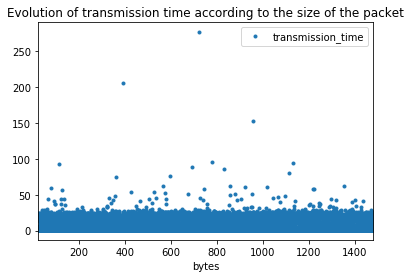

In [172]:
data_1 = data.query('bytes < 1480')
data_1 = data_1.reset_index(drop = True)
data_1.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of the packet", style='.')

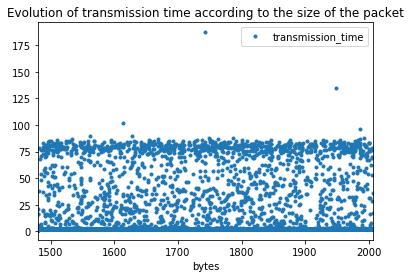

In [173]:
data_2 = data.query('bytes >= 1480')
data_2 = data_2.reset_index(drop = True)
data_2.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of the packet", style='.')

#### Linear regression data 1 with sklearn

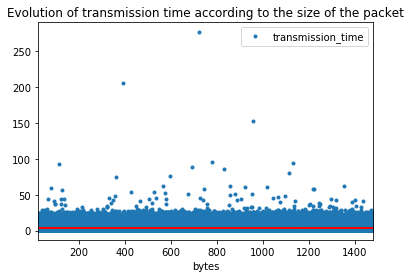

In [174]:
linear_regressor = LinearRegression()
linear_regressor.fit(data_1['bytes'].values.reshape(-1, 1), data_1['transmission_time'].values.reshape(-1, 1))
Y_pred = linear_regressor.predict(data_1['bytes'].values.reshape(-1, 1))
data_1.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of the packet", style='.')
plt.plot(data_1['bytes'].values.reshape(-1, 1), Y_pred, color='red')

In [175]:
linear_regressor.coef_

array([[0.00032406]])

In [176]:
linear_regressor.intercept_

array([3.27680784])

As we plot T(S) = L + S/C, .coef_ corresponds to 1/C and .intercept_ corresponds to L.

1/C = 0.00032406 so C = 1/0.00032406 = 3085.8482997 bytes per sec

L = 3.27680784 ms

#### Linear regression data 2 with sklearn

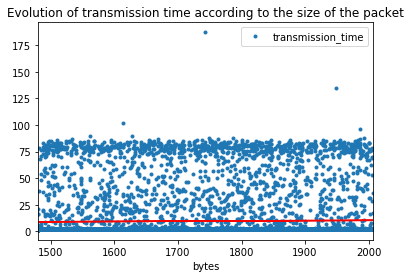

In [177]:
linear_regressor2 = LinearRegression()
linear_regressor2.fit(data_2['bytes'].values.reshape(-1, 1), data_2['transmission_time'].values.reshape(-1, 1))
Y_pred = linear_regressor2.predict(data_2['bytes'].values.reshape(-1, 1))
data_2.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of the packet", style='.')
plt.plot(data_2['bytes'].values.reshape(-1, 1), Y_pred, color='red')

In [178]:
linear_regressor2.coef_

array([[0.00265805]])

In [179]:
linear_regressor2.intercept_

array([5.14486173])

1/C = 0.00265805 so C = 1/0.00265805 = 376.215646809 bytes per sec

L = 5.14486173 ms

We can see that the capacity was divided by 10 and the latency is higher for the second part of the data. So when the packets are bigger, the performance decrease.

#### Linear regression data 1 with statsmodels

In [180]:
X = data_1['bytes']
X = np.vander(X, 2)
y = data_1['transmission_time']
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      transmission_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.52
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           0.000139
Time:                        17:17:04   Log-Likelihood:            -1.0709e+05
No. Observations:               32649   AIC:                         2.142e+05
Df Residuals:                   32647   BIC:                         2.142e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003    8.5e-05      3.811      0.000       0.000       0.000
const          3.2768      0.072     45.302      0.000       3.135       3.419
==============================================================================
Omnibus:                    41891.755   Durbin-Watson:                   0.638
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         31015048.290
Skew:                           6.584   Prob(JB):                         0.00
Kurtosis:                     153.418   Cond. No.                     1.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The linear regression with statsmodels doesn't include an intercept by default like scikit-learn does. Without the line "np.vander(X,2)", we would obtain only one coef but we do not want that. That is why we use numpy.vander

#### Linear regression data 2 with statsmodels

In [181]:
X2 = data_2['bytes']
X2 = np.vander(X2, 2)
y2 = data_2['transmission_time']
model2 = sm.OLS(y2, X2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      transmission_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.329
Date:                Sun, 15 Dec 2019   Prob (F-statistic):             0.0375
Time:                        17:17:04   Log-Likelihood:                -50677.
No. Observations:               11387   AIC:                         1.014e+05
Df Residuals:                   11385   BIC:                         1.014e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0027      0.001      2.081      0.037       0.000       0.005
const          5.1449      2.237      2.300      0.021       0.760       9.529
==============================================================================
Omnibus:                     6246.259   Durbin-Watson:                   0.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33888.381
Skew:                           2.766   Prob(JB):                         0.00
Kurtosis:                       9.389   Cond. No.                     2.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I have done the linear regression with two different technics. At the end we see that we have more or less the same coefficients (x1 coef = a and const coef = b in ax+b for statsmodels). However, we can display more information with statsmodels and we can see clearly that R^2 is equal to zero for the two part of the data, so the linear regression is irrelevant.

### Question 4/

Quantile regression is less sensitive to outliers.

#### Quantile regression with statsmodels for data set 1

In [184]:
mod = smf.quantreg('transmission_time ~ bytes', data_1)
res = mod.fit(q=.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:      transmission_time   Pseudo R-squared:              0.01605
Model:                       QuantReg   Bandwidth:                     0.01691
Method:                 Least Squares   Sparsity:                       0.2208
Date:                Sun, 15 Dec 2019   No. Observations:                32649
Time:                        17:19:35   Df Residuals:                    32647
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1391      0.001    917.512      0.000       1.137       1.142
bytes          0.0002   1.46e-06    169.536      0.000       0.000       0.000
==============================================================================

The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

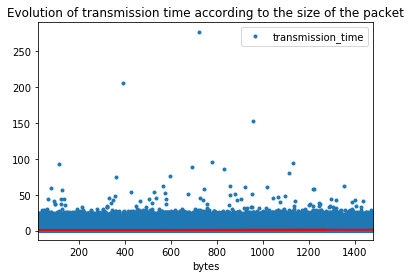

In [186]:
data_1.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of the packet", style='.')
calculate_y_quantile = lambda a, b: a * data_1['bytes'] + b
y_quantile = calculate_y_quantile(0.0002, 1.1391)
plt.plot(data_1['bytes'], y_quantile, color='red')

#### Quantile regression with statsmodels for data set 2

In [187]:
mod2 = smf.quantreg('transmission_time ~ bytes', data_2)
res2 = mod2.fit(q=.5)
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:      transmission_time   Pseudo R-squared:            0.0006485
Model:                       QuantReg   Bandwidth:                     0.02976
Method:                 Least Squares   Sparsity:                       0.2720
Date:                Sun, 15 Dec 2019   No. Observations:                11387
Time:                        17:34:55   Df Residuals:                    11385
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8843      0.015    128.419      0.000       1.856       1.913
bytes          0.0002   8.38e-06     29.490      0.000       0.000       0.000
==============================================================================

The condition number is large, 2.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

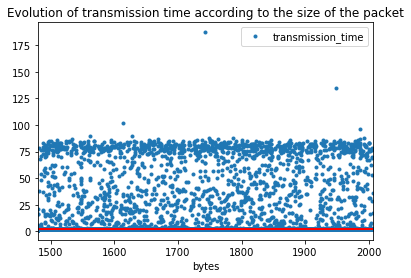

In [188]:
data_2.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of the packet", style='.')
calculate_y2_quantile = lambda a, b: a * data_2['bytes'] + b
y2_quantile = calculate_y2_quantile(0.0002, 1.8843)
plt.plot(data_2['bytes'], y2_quantile, color='red')

The intercept is lower in both data set with the quantile regression method. This method is based on the mediane, we have then a regression more precise.

## Second data set

In [182]:
url = 'http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz'
urllib.request.urlretrieve(url, '/tmp/stackoverflow.log.gz')
os.system('gunzip /tmp/stackoverflow.log.gz')
os.system('sed -e "s/\[/ /"  -e "s/]/,/" -e "s/bytes.*time=/,/" -e "s/ms/ /" /tmp/stackoverflow.log > /tmp/ping_stackoverflow.log')
raw_data2 = pd.read_table("/tmp/ping_stackoverflow.log", header=None, sep=',', engine='python')

In [183]:
raw_data2.columns = ['time', 'bytes','transmission_time']
raw_data2

,time,bytes,transmission_time
0,1.421771e+09,1257,120.0
1,1.421771e+09,454,120.0
2,1.421771e+09,775,126.0
3,1.421771e+09,1334,112.0
4,1.421771e+09,83,111.0
...,...,...,...
6882,1.421773e+09,1696,111.0
6883,1.421773e+09,561,111.0
6884,1.421773e+09,773,111.0
6885,1.421773e+09,1009,111.0
